In [1]:
from __future__ import division
import cv2
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from scipy.signal import convolve2d
import matplotlib.pyplot as plt
from preprocessing import *


In [2]:
def lpq(img,winSize=3,freqestim=1,mode='nh'):
    rho=0.90

    STFTalpha=1/winSize  # alpha in STFT approaches (for Gaussian derivative alpha=1)
    sigmaS=(winSize-1)/4 # Sigma for STFT Gaussian window (applied if freqestim==2)
    sigmaA=8/(winSize-1) # Sigma for Gaussian derivative quadrature filters (applied if freqestim==3)

    convmode='valid' # Compute descriptor responses only on part that have full neigborhood. Use 'same' if all pixels are included (extrapolates np.image with zeros).

    img=np.float64(img) # Convert np.image to double
    r=(winSize-1)/2 # Get radius from window size
    x=np.arange(-r,r+1)[np.newaxis] # Form spatial coordinates in window

    if freqestim==1:  #  STFT uniform window
        #  Basic STFT filters
        w0=np.ones_like(x)
        w1=np.exp(-2*np.pi*x*STFTalpha*1j)
        w2=np.conj(w1)

    ## Run filters to compute the frequency response in the four points. Store np.real and np.imaginary parts separately
    # Run first filter
    filterResp1=convolve2d(convolve2d(img,w0.T,convmode),w1,convmode)
    filterResp2=convolve2d(convolve2d(img,w1.T,convmode),w0,convmode)
    filterResp3=convolve2d(convolve2d(img,w1.T,convmode),w1,convmode)
    filterResp4=convolve2d(convolve2d(img,w1.T,convmode),w2,convmode)

    # Initilize frequency domain matrix for four frequency coordinates (np.real and np.imaginary parts for each frequency).
    freqResp=np.dstack([filterResp1.real, filterResp1.imag,
                        filterResp2.real, filterResp2.imag,
                        filterResp3.real, filterResp3.imag,
                        filterResp4.real, filterResp4.imag])

    ## Perform quantization and compute LPQ codewords
    inds = np.arange(freqResp.shape[2])[np.newaxis,np.newaxis,:]
    LPQdesc=((freqResp>0)*(2**inds)).sum(2)

    ## Switch format to uint8 if LPQ code np.image is required as output
    if mode=='im':
        LPQdesc=np.uint8(LPQdesc)

    ## Histogram if needed
    if mode=='nh' or mode=='h':
        LPQdesc=np.histogram(LPQdesc.flatten(),range(256))[0]

    ## Normalize histogram if needed
    if mode=='nh':
        LPQdesc=LPQdesc/LPQdesc.sum()

    return LPQdesc

In [3]:
def Train_NN(X,Y):
    print("Start Training ")
    N = len(X[0])
    X = np.array(X)
    Y = np.array(Y)
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=4, stratify=Y)
    clf = MLPClassifier(alpha=1e-05, hidden_layer_sizes=(500,250),random_state=1,solver='lbfgs',max_iter=10000)
    clf = clf.fit(x_train, y_train)
    print("Finished Fitting")
    y_pred_test = clf.predict(x_test)
    accuracy_test = np.mean(y_test==y_pred_test) * 100
    
    y_pred_train = clf.predict(x_train)
    accuracy_train = np.mean(y_train==y_pred_train) * 100
    return (accuracy_train,accuracy_test),clf

In [4]:
base_dir='ACdata_base/'

fonts = os.listdir(base_dir)
X,Y=[],[]
for font in fonts:
    h,w = 0,0
    data = os.listdir(base_dir+font)
    print("curFont",font)
    for img in data:
        img_dir = base_dir+font+'/'+img
        imgGray = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
        bin = Binarize_Histogram(imgGray)
        lp = lpq(bin,winSize=3,freqestim=1,mode='nh')
        X.append(lp)
        Y.append(int(font))

curFont 1
curFont 2
curFont 3
curFont 4
curFont 5
curFont 6
curFont 7
curFont 8
curFont 9


In [5]:
accuracy,clf = Train_NN(X,Y)

Start Training 
Finished Fitting


In [6]:
print("Accuracy Train: ",accuracy)

Accuracy Train:  (98.89152810768013, 94.54976303317537)


(array([  3,  13,  25,  49,  54,  69,  83, 131, 140, 170, 211, 221, 258,
       269, 279, 288, 300, 338, 370, 376, 381, 389, 403], dtype=int64),)
[6.12568804e-09 9.99998044e-01 7.64048335e-10 6.24256007e-11
 1.74037084e-07 2.14392420e-11 5.01189767e-20 1.77522819e-06
 3.39443073e-26] 2 2
[1, 2, 3, 4, 5, 6, 7, 8, 9]


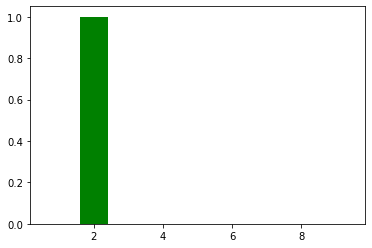

accuracy:  94.54976303317537


In [7]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=4, stratify=Y)
test_idx=1
plt.show()
y_pred = clf.predict(x_test)
y_pred_prop = clf.predict_proba(x_test)
accuracy = np.mean(y_test==y_pred)
print(np.where(y_test!=y_pred))
print(y_pred_prop[test_idx],y_pred[test_idx],y_test[test_idx])
y_axis = list(range(1,10))
plt.bar(y_axis, y_pred_prop[test_idx], color ='green')
print(y_axis)
plt.show()
print("accuracy: ",accuracy*100)